#### Dirichlet-multinomial distribution

### http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymc3 as pm

import pandas as pd

In [9]:
def display_probs(d):
    for key, value in d.items():
        print(f'Species: {key:8} Prevalence: {100*value:.2f}%.')

In [6]:
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])


In [7]:
# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

In [10]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


### These values are expected. W ea renot taking the factor of uncertainity due to the limited data when we are computing this. 

In [11]:
# unequal hyper parameter values:
alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

In [15]:
values = []

for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


In [17]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')
melted

,alphas,species,prevalence
0,[0.1 0.1 0.1],lions,0.492063
1,[1 1 1],lions,0.444444
2,[5 5 5],lions,0.380952
3,[15 15 15],lions,0.352941
4,[0.1 0.1 0.1],tigers,0.333333
5,[1 1 1],tigers,0.333333
6,[5 5 5],tigers,0.333333
7,[15 15 15],tigers,0.333333
8,[0.1 0.1 0.1],bears,0.174603
9,[1 1 1],bears,0.222222


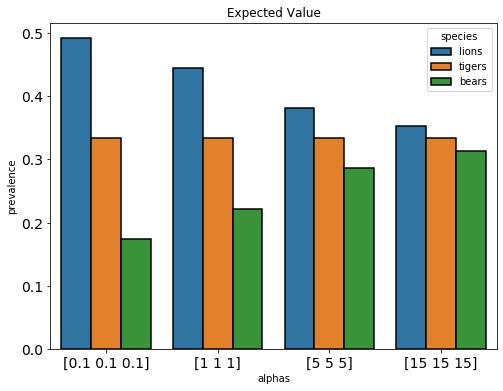

In [19]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

### as the hyperparameter value increases, the expected prevelance converges to 0.333.  with heavier priors, the observations matter less 

### on the other hand if the weights of hyperparameter is less then the observed data matters more and the expected value converges to counts. 
### the value of hyperparameter depends on our confidence in prior belied